Iteration 0, Error: 0.19410227780433603
Iteration 1, Error: 0.2870456484414055
Iteration 2, Error: 0.4859171455804473
Iteration 3, Error: 0.191236060241849
Iteration 4, Error: 0.1731055449103556
Iteration 5, Error: 0.07673699285214036
Iteration 6, Error: 0.029019456776817026
Iteration 7, Error: 0.002276095861219934
Iteration 8, Error: 0.00023948677321668227
Iteration 9, Error: 1.682871943262882e-05
Iteration 10, Error: 0.0
Iteration 0, Error: 0.359707620292062
Iteration 1, Error: 0.01974223622184918
Iteration 2, Error: 0.0026185263306080773
Iteration 3, Error: 0.00014117311513838887
Iteration 4, Error: 1.0274715942794094e-05
Iteration 5, Error: 1.3263364091508015e-06
Iteration 6, Error: 1.5790734913785237e-07
Iteration 7, Error: 9.91987714214146e-09
Iteration 8, Error: 2.6354983229271176e-10
Iteration 9, Error: 1.6705981763858902e-11
Iteration 10, Error: 7.85812699276133e-13
Iteration 11, Error: 2.055296431358608e-14
Iteration 12, Error: 1.3963797410504342e-15
Iteration 0, Error: 0.033

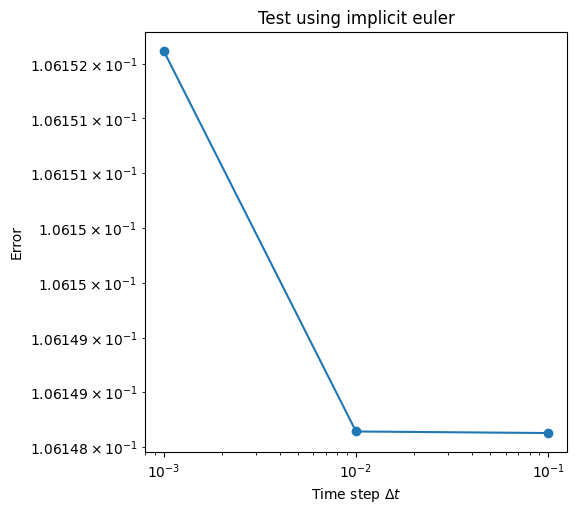

(array([0.1  , 0.01 , 0.001]),
 array([0.10614813, 0.10614814, 0.10615161]),
 array([-5.80855220e-08, -1.42002019e-05]),
 -7.129143721871227e-06)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from parareal.parareal.mpi_parareal import parareal
from scipy.integrate import solve_ivp
from parareal.solver.beuler import beuler
from parareal.solver.feuler import feuler
from parareal.solver.rk4 import rk4
from parareal.solver.rk2 import rk2
from parareal.lorenz.lorenz import lorenz
from parareal.test_func import *
from mpi4py import MPI

def convergence_test(F,G,tspan,y0,max_iter, f_exacte):
    Ns = np.array([10,100,1000])
    dts=[]
    errors = []
    
    for n in Ns:
        t, _, sol1 = parareal(G, F, tspan, y0, n, max_iter,tol=1e-14)
        sol_exacte =  f_exacte(t)
        errors.append(np.max(np.abs(sol1-sol_exacte)))
        dts.append(t[1]-t[0])
    
    errors = np.array(errors)
    dts = np.array(dts)
    
    
    convergence_rates = np.log(errors[:-1] / errors[1:]) / np.log(dts[:-1] / dts[1:])
    order_of_convergence = np.mean(convergence_rates)
    
    if MPI.COMM_WORLD.Get_rank() == 0:
        print("Time steps:", dts)
        print("Errors:", errors)
        print("Convergence rates:", convergence_rates)
        print("Order of convergence:", order_of_convergence)

        fig = plt.figure(figsize=(12, 12))
        ax1 = fig.add_subplot(221)
        ax1.loglog(dts, errors, '-o')
        ax1.set_xlabel('Time step $\Delta t$')
        ax1.set_ylabel('Error')
        ax1.set_title('Test using implicit euler')
        plt.show()
    
    return dts, errors, convergence_rates, order_of_convergence

Nh = 100000
tspan = [0, 10] 
y0 = [1] 
tol = 1e-1
max_iter = 100
G_Nh=1
F_Nh=10



G1 = lambda tspan,u0, :feuler(h, tspan, u0, G_Nh)[1][-1]
F1 = lambda tspan,u0, :rk2(h, tspan, u0, F_Nh)[1][-1]

G2 = lambda tspan,u0, :solve_ivp(h, tspan, u0, method='RK23').y[:, -1]
F2 = lambda tspan,u0, :solve_ivp(h, tspan, u0, method='RK45').y[:, -1]

#convergence_test(F1,G1,tspan,y0,Nh,max_iter, h_exacte)
#convergence_test(F2,G2,tspan,y0,Nh,max_iter, h_exacte)

# Model parameters
sigma, rho, beta = 10.0, 28.0, 8/3
U0 = np.array([5.0, -5.0, 20.0])
tspan = [0, 1]
lorenz_ = lambda t,state:lorenz(t, state, sigma, rho, beta)

#Parareal params
N = 180
tol = 1e-10
max_iter = 75
G_Nh=1
F_Nh=80
G3 = lambda tspan,u0, :beuler(lorenz_, tspan, u0, G_Nh)[1][-1]
F3 = lambda tspan,u0, :rk4(lorenz_, tspan, u0, F_Nh)[1][-1]

t_eval = np.linspace(tspan[0], tspan[1], 100000)
sol_ref = solve_ivp(lorenz_, tspan, U0, method='RK45', t_eval=t_eval)
def lorenz_ref(t):
    # Interpolation de la solution de référence pour correspondre aux temps calculés
    x = np.interp(t, sol_ref.t, sol_ref.y[0,:])
    y = np.interp(t, sol_ref.t, sol_ref.y[1,:])
    z = np.interp(t, sol_ref.t, sol_ref.y[2,:])
    return np.stack((x,y,z),axis=1)
convergence_test(F3,G3,tspan,U0,max_iter, lorenz_ref)



